## Import Toolkit

In [33]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint

#Warnings
import warnings
warnings.filterwarnings('ignore')

## Upload Data

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
# import os
# os.chdir('/content/drive/MyDrive/5_AIADVANCE')

In [36]:
# root_dir = '/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/'
root_dir = 'Data'

# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [37]:
img_size = (224 , 224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 349 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


## Show Sample From Train Data

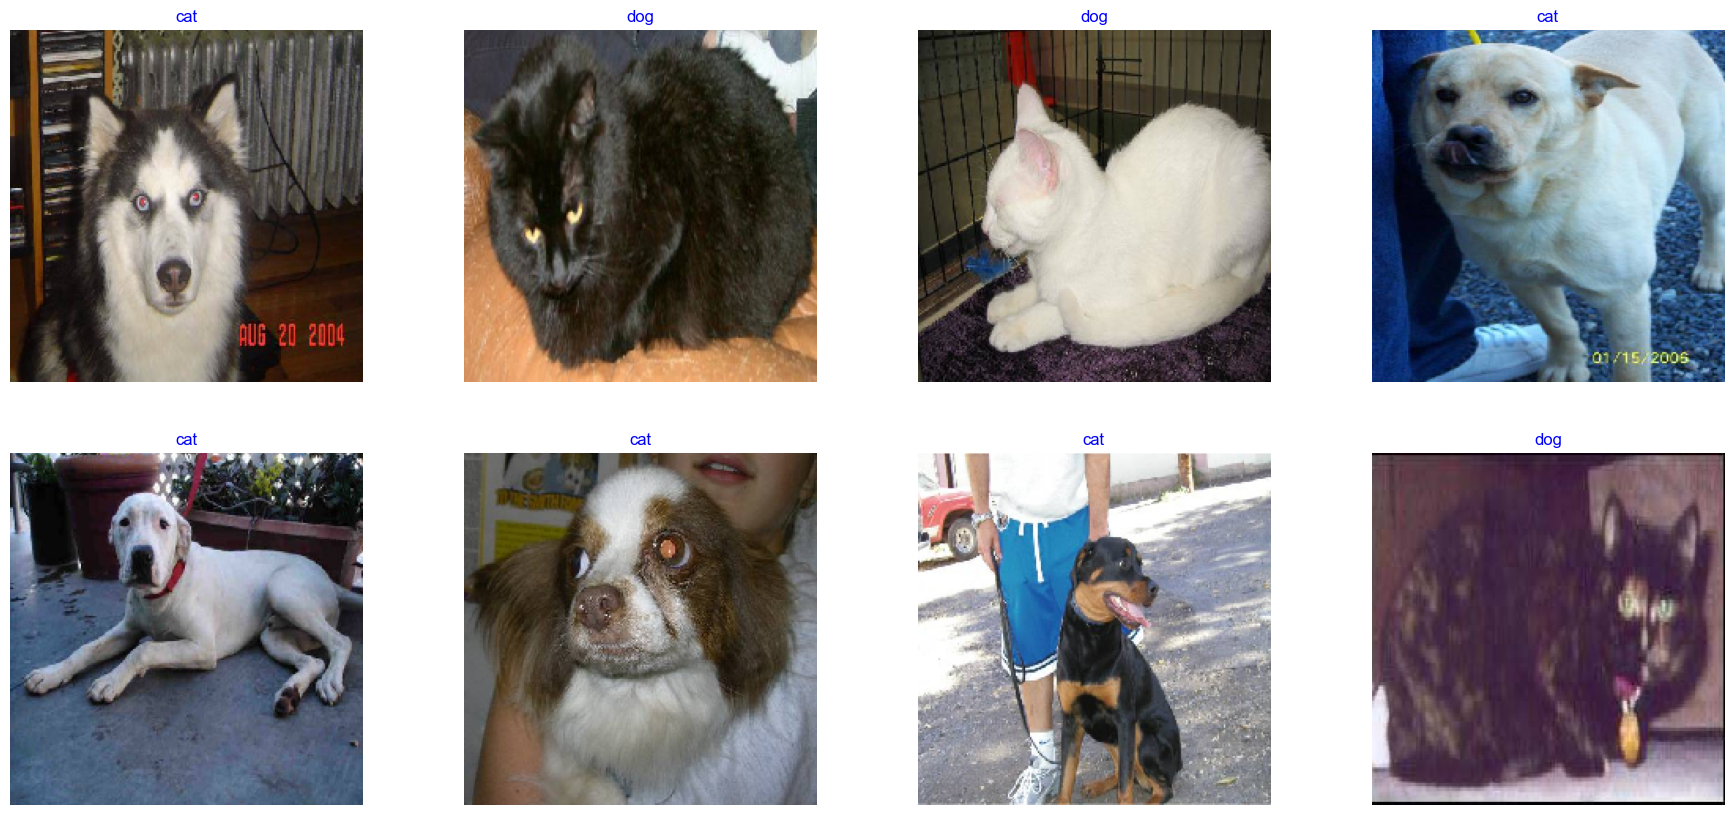

In [38]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    # class_index = int(labels[i]) # binary 
    class_index = int(labels[i][0]) # categorical
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

## Model

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, Add, GlobalAveragePooling2D, Reshape, Dropout, Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

def swish(x):
    return x * Activation('sigmoid')(x)

def efficientnet_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(inputs)
    x = BatchNormalization()(x)
    x = swish(x)
    return x

def mb_conv_block(inputs, filters, kernel_size, strides, expand_ratio):
    depth_filters = round(filters * expand_ratio)
    x = efficientnet_block(inputs, depth_filters, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel_size, strides=strides, padding='same', depthwise_initializer=he_normal(), depthwise_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = swish(x)
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    if strides == (1, 1):
        x = Add()([inputs, x])
    return x

def build_efficientnet_b7(input_shape=(224, 224, 3), num_classes=1000, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # Define block arguments
    blocks_args = [
        {'kernel_size': 3, 'repeats': 1, 'filters': 16, 'expand_ratio': 1, 'strides': 1},
        {'kernel_size': 3, 'repeats': 2, 'filters': 24, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 5, 'repeats': 2, 'filters': 40, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 3, 'repeats': 3, 'filters': 80, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 5, 'repeats': 3, 'filters': 112, 'expand_ratio': 6, 'strides': 1},
        {'kernel_size': 5, 'repeats': 4, 'filters': 192, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 3, 'repeats': 1, 'filters': 320, 'expand_ratio': 6, 'strides': 1}
    ]

    # Building the stem
    x = efficientnet_block(inputs, 64, (3, 3), strides=(2, 2))

    # Building blocks
    for block_args in blocks_args:
        num_repeat = block_args.pop('repeats')
        for _ in range(num_repeat):
            x = mb_conv_block(x, **block_args)

    # Building the head
    x = Conv2D(2560, (1, 1), padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = swish(x)

    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    x = Dense(num_classes, activation='softmax', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(x)

    # Create model
    model = Model(inputs, x, name='EfficientNetB7')

    return model

# Create EfficientNet B7 model
effnet_b7_model = build_efficientnet_b7(num_classes = 2)
# effnet_b7_model.summary()

In [40]:
# Tạo đối tượng optimizer  # SGD
optimizer = tf.keras.optimizers.Adam()

# Thiết lập ModelCheckpoint
save_best_only = True
checkpoint = ModelCheckpoint('models/model-Effnet_b7_model-{epoch:03d}.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
effnet_b7_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = effnet_b7_model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.samples // valid_gen.batch_size,
    epochs = 20,
    callbacks=[checkpoint]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5094 - loss: 1.7420
Epoch 1: val_loss improved from inf to 0.99833, saving model to models/model-Effnet_b7_model-001.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 412ms/step - accuracy: 0.5092 - loss: 1.7416 - val_accuracy: 0.5208 - val_loss: 0.9983
Epoch 2/20
 1/43 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.6250 - loss: 1.1046
Epoch 2: val_loss improved from 0.99833 to 0.50419, saving model to models/model-Effnet_b7_model-002.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6250 - loss: 0.5652 - val_accuracy: 0.3333 - val_loss: 0.5042
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.5882 - loss: 1.2578
Epoch 3: val_loss did not improve from 0.50419
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - accuracy: 0.5873 - loss: 1.2589 - val_accuracy: 0.5312 - val_loss: 0.9980
Epoch 4/20
 1/43 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.6250 - loss: 1.1911
Epoch 4: val_loss did not improve from 0.5041

## Model Performance

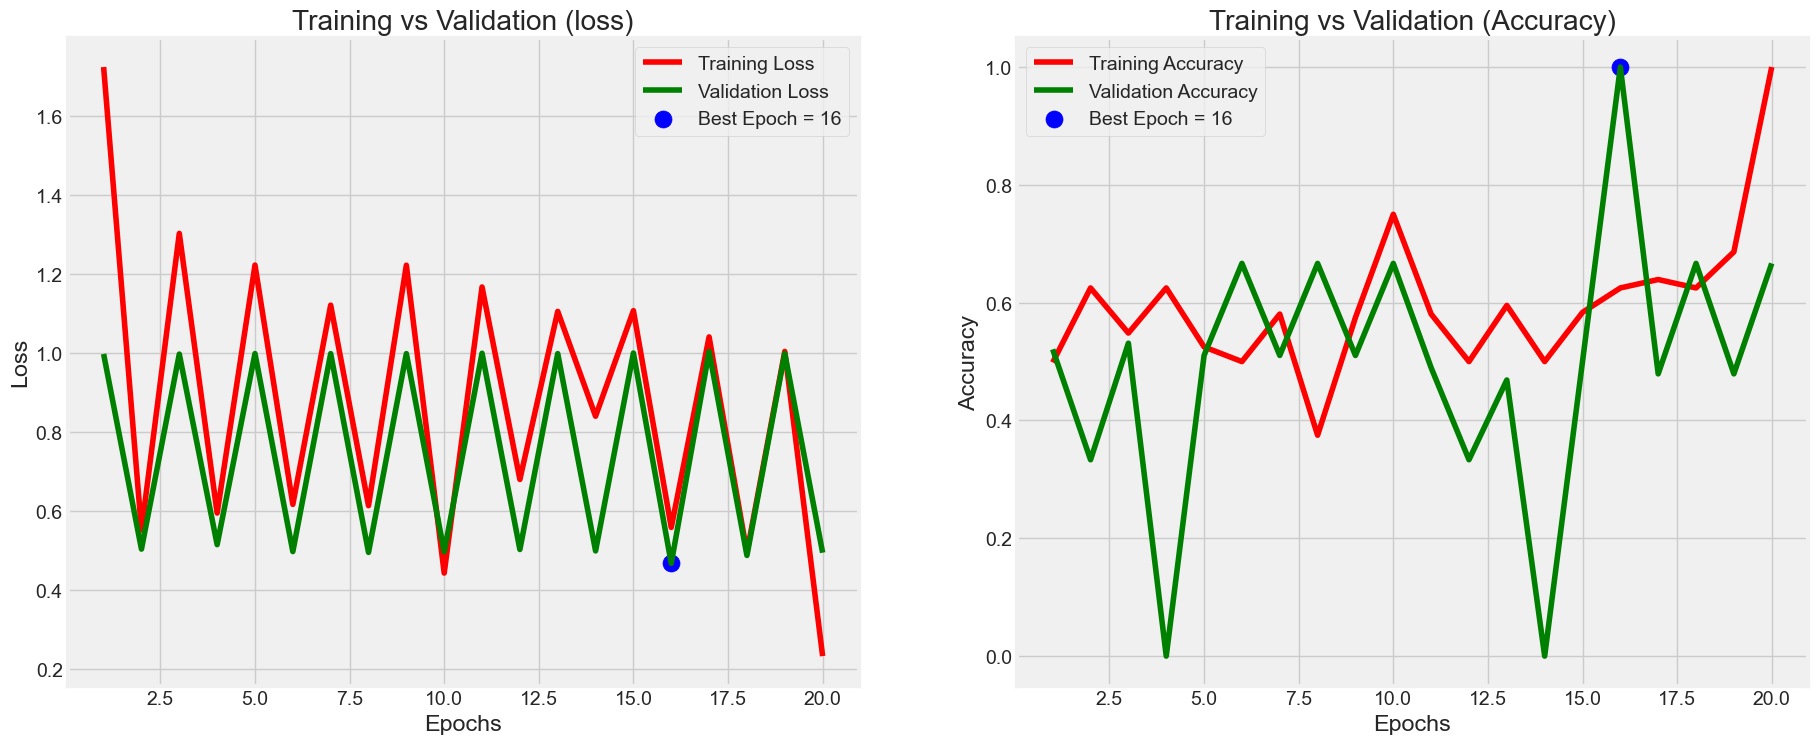

In [41]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [42]:
train_score = effnet_b7_model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = effnet_b7_model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = effnet_b7_model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5324 - loss: 0.9971
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4470 - loss: 0.9583
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4193 - loss: 0.9039 
Train loss = 0.999745786190033
Train Accuracy = 0.48046875
Validation loss = 0.9269604682922363
Validation Accuracy = 0.4848484992980957
Test loss = 0.8731155395507812
Test Accuracy = 0.48076921701431274


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = effnet_b7_model.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepWARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A3F26A4160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
F1: 0.31218781218781216
Precision: 0.2311390532544379
Recall: 0.4807692307692308


In [44]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.48      1.00      0.65        25

    accuracy                           0.48        52
   macro avg       0.24      0.50      0.32        52
weighted avg       0.23      0.48      0.31        52



## Model Prediction

## Confusion Matrix and Classification Report

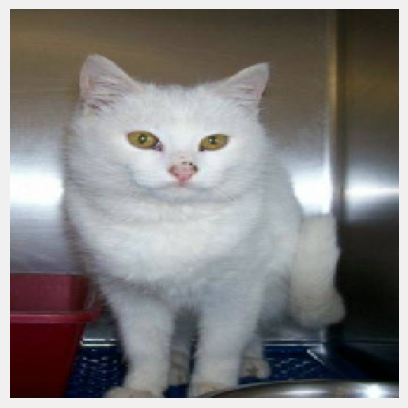

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
Dự đoán: 1


In [45]:
# Lấy 1 batch dữ liệu từ generator
batch = next(test_gen)
# In hình ảnh đầu tiên
img = batch[0][0]
img = img.astype(float)/255
plt.imshow(img)
plt.axis('off')
plt.show()

# Chuyển đổi thành 4D tensor
img = np.expand_dims(img, axis=0)

# Dự đoán
pred = effnet_b7_model.predict(img)
print('Dự đoán:', np.argmax(pred))

In [46]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

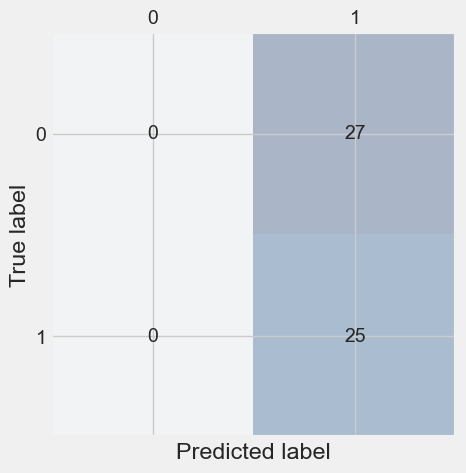

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i,j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()